In [7]:
import pandas as pd
import plotnine as pn
import patchworklib as pw
print(pw.__version__)
print(pn.__version__)

0.5.0
0.8.0


## Read data

In [8]:
# Filepaths

filepaths = [
    'half_credit_literal',
    'indicator_literal',
    'half_credit_pragmatic',
    'indicator_pragmatic',
]

get_fp = lambda setting: f'../../outputs/journal/{setting}/analysis/all_data.csv'
filepaths = {key: get_fp(key) for key in filepaths}

In [9]:
# Load dataframes

half_credit_literal_data = pd.read_csv(filepaths['half_credit_literal'])
indicator_literal_data = pd.read_csv(filepaths['indicator_literal'])
half_credit_pragmatic_data = pd.read_csv(filepaths['half_credit_pragmatic'])
indicator_pragmatic_data = pd.read_csv(filepaths['indicator_pragmatic'])

## Generate multiplot

##### sanity check plots first

In [10]:
def get_plot(input_data):

    data = input_data.copy() # this helps

    pareto_data = data[data["dominant"] == True]
    natural_data = data[data["natural"] == True]

    og_data = data.copy()
    subset = ["complexity", "comm_cost"]
    vcs = data.value_counts(subset=subset, sort=False)
    data = og_data.drop_duplicates(subset=subset)  # drop dupes from original
    data = data.sort_values(by=subset)
    data["counts"] = vcs.values

    # aesthetics for all data
    kwargs = {
        "color": "iff",
        "size": "counts",
    }

    plot = (
        # Set data and the axes
        pn.ggplot(mapping=pn.aes(x="complexity", y="comm_cost"))
        # + pn.scale_y_continuous(limits=[0, 1])
        + pn.geom_point(data=pareto_data)
        + pn.geom_point(  # all langs
            data=data,
            stroke=0,
            alpha=1,
            mapping=pn.aes(**kwargs),
        )
        # + pn.xlab("Complexity")
        # + pn.ylab("Communicative cost")
        + pn.scale_color_cmap("cividis")
        + pn.theme_classic()
    )
    if natural_data is not None:
        plot = (
            plot
            + pn.geom_point(  # The natural languages
                natural_data,
                color="red",
                shape="+",
                size=4,
            )
            # + pn.geom_text(
            #     natural_data,
            #     pn.aes(label="name"),
            #     ha="left",
            #     size=6,  # orig 9
            #     nudge_x=1,
            # )
        )
    return plot

### define individual subplots

In [11]:
margin = {"t":0, "b":150, "l":0, "r":0} # roll with it

# Upper left
hcl_plot = (
    get_plot(half_credit_literal_data)
    + pn.ggtitle("Literal Informativeness")
    + pn.ylab("Graded Communicative Utility")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                plot_title=pn.element_text(margin=margin),
                axis_title_y=pn.element_text(margin={"t":0, "b":0, "l":0, "r":20})
        )
)

# Upper right
hcp_plot = (
    get_plot(half_credit_pragmatic_data)
    + pn.ggtitle("Pragmatic Informativeness")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='right',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
                plot_title=pn.element_text(margin=margin),
        )
)

# Lower left
il_plot = (
    get_plot(indicator_literal_data)
    + pn.ylab("Binary Communicative Utility")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_text(margin={"t":0, "b":0, "l":0, "r":20})
        )        
)

# Lower right
ip_plot =  (
    get_plot(indicator_pragmatic_data) 
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
        )
)

#### Stitch together multiplot with patchworklib

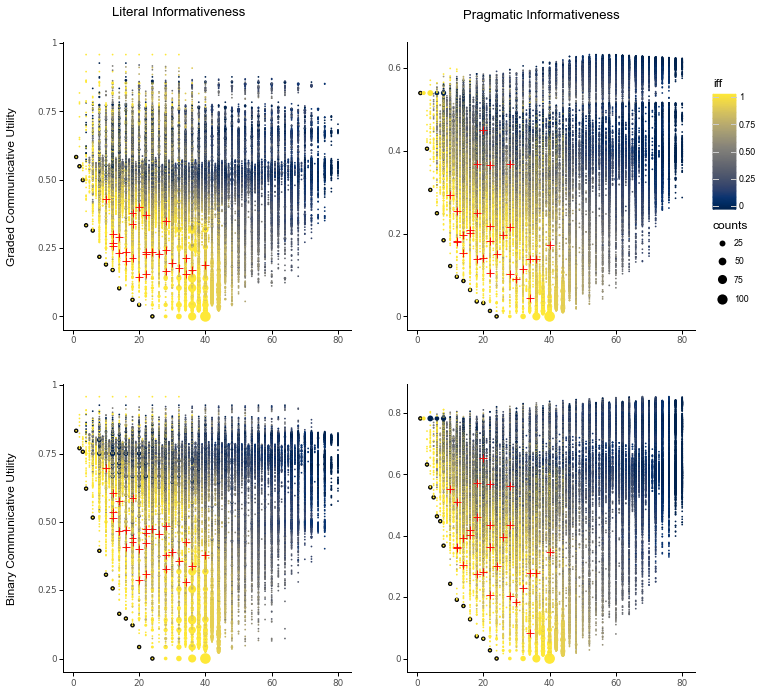

In [12]:
g_hcl = pw.load_ggplot(hcl_plot, figsize=(4,4))
g_hcp = pw.load_ggplot(hcp_plot, figsize=(4,4))
g_il = pw.load_ggplot(il_plot, figsize=(4,4))
g_ip = pw.load_ggplot(ip_plot, figsize=(4,4))

g = (g_hcl | g_hcp) / (g_il | g_ip)
g.savefig("multiplot.png")